# Predicting housing prices


Data is from Kaggle dataset on [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))


house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


## Data exploration:


In [104]:
house_prices_df.shape

(1460, 81)

In [105]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [106]:
house_prices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [107]:
# Checking for duplicate entries:

idsUnique = len(set(house_prices_df['id']))
idsTotal = house_prices_df.shape[0]
duplicates = idsTotal - idsUnique

print('There are {} duplicate IDs for {} total entries'.format(duplicates, idsTotal))

There are 0 duplicate IDs for 1460 total entries


In [108]:
house_prices_df.drop('id', axis = 1, inplace=True)

In [109]:
# first, organizing the numerical and non-numerical data:
# Numerical features:
numerical = house_prices_df.dtypes[house_prices_df.dtypes != "object"].index
numerical.ravel()


array(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype=object)

In [110]:
# Non-numerical features:

non_numerical = house_prices_df.dtypes[house_prices_df.dtypes == "object"].index
non_numerical.ravel()

array(['mszoning', 'street', 'alley', 'lotshape', 'landcontour',
       'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating',
       'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish',
       'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence',
       'miscfeature', 'saletype', 'salecondition'], dtype=object)

In [111]:
# Make a copy of the orginal df to work with
#house_prices_df2 = house_prices_df.copy()

# converting all non-numerical columns to numerical, by one-hot encoding them
# this will make the whole house_prices_df2 have continuous features
for variable in non_numerical:
    house_prices_df = pd.concat([house_prices_df, pd.get_dummies(house_prices_df[variable], prefix=variable, drop_first=True)], axis=1)
    
house_prices_df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,0,0,1,0,0,0,1,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,0,0,1,0,0,0,1,0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,0,0,1,0,0,0,1,0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,0,0,1,0,0,0,0,0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,0,0,1,0,0,0,1,0


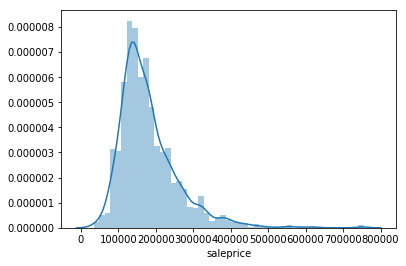

In [113]:
sns.distplot(house_prices_df.saleprice)

In [96]:
house_prices_df.columns.ravel()

array(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagefinish',
       'garagecars', 'garagearea', 'garagequal', 'garagecond',
     

In [97]:
for variable in non_numerical:
    house_prices_df.drop(variable, axis=1, inplace=True)
    


In [98]:
house_prices_df.columns.ravel()

array(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice',
       'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM',
       'street_Pave', 'alley_Pave', 'lotshape_IR2', 'lotshape_IR3',
       'lotshape_Reg', 'landcontour_HLS', 'landcontour_Low',
       'landcontour_Lvl', 'utilities_NoSeWa', 'lotconfig_CulDSac',
       'lotconfig_FR2', 'lotconfig_FR3', 'lotconfig_Inside',
       'landslope_Mod', 'landslope_Sev', 'neighborhood_Blueste',
       'neighborhood_BrDal

In [101]:
# Finding the top 10 most correlated features:

np.abs(house_prices_df.corr().loc[:,'saleprice']).sort_values(ascending=False).head(20).index


Index(['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea',
       'totalbsmtsf', 'firstflrsf', 'exterqual_TA', 'fullbath', 'totrmsabvgrd',
       'yearbuilt', 'kitchenqual_TA', 'yearremodadd', 'foundation_PConc',
       'garageyrblt', 'masvnrarea', 'fireplaces', 'exterqual_Gd',
       'bsmtqual_TA', 'bsmtfintype1_GLQ'],
      dtype='object')

In [100]:
house_prices_df[house_prices_df == 0].index

RangeIndex(start=0, stop=1460, step=1)

In [126]:
# Feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea',
       'totalbsmtsf', 'firstflrsf', 'exterqual_TA', 'fullbath', 'totrmsabvgrd',
       'yearbuilt', 'kitchenqual_TA', 'yearremodadd', 'foundation_PConc',
       'garageyrblt', 'masvnrarea', 'fireplaces', 'exterqual_Gd',
       'bsmtqual_TA', 'bsmtfintype1_GLQ']]
X.fillna(0, inplace=True)
# Target 
Y = house_prices_df.saleprice



In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [128]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [129]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7972389179748027
-----Test set statistics-----
R-squared of the model in test set is: 0.7929348745081014
Mean absolute error of the prediction is: 23946.134053185047
Mean squared error of the prediction is: 1390173977.6488092
Root mean squared error of the prediction is: 37285.03691360395
Mean absolute percentage error of the prediction is: 14.219170623815788


In [130]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 100.0
R-squared of the model in training set is: 0.7970077898008548
-----Test set statistics-----
R-squared of the model in test set is: 0.792005300546678
Mean absolute error of the prediction is: 23933.186697286757
Mean squared error of the prediction is: 1396414862.145419
Root mean squared error of the prediction is: 37368.63473750973
Mean absolute percentage error of the prediction is: 14.175598583161609


In [131]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7964935502248173
-----Test set statistics-----
R-squared of the model in test set is: 0.7904797542930218
Mean absolute error of the prediction is: 24031.61198160848
Mean squared error of the prediction is: 1406656928.2514048
Root mean squared error of the prediction is: 37505.425317564455
Mean absolute percentage error of the prediction is: 14.180030221160312


In [132]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7969010173772351
-----Test set statistics-----
R-squared of the model in test set is: 0.7914168538314938
Mean absolute error of the prediction is: 24006.819077044445
Mean squared error of the prediction is: 1400365519.2574675
Root mean squared error of the prediction is: 37421.4580055009
Mean absolute percentage error of the prediction is: 14.197114332881425
